<a href="https://colab.research.google.com/github/srilakshmi-saladi/bdaassignment/blob/main/Retinal_Vessel_Segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ipythonx_retinal_vessel_segmentation_path = kagglehub.dataset_download('ipythonx/retinal-vessel-segmentation')

print('Data source import complete.')


In [3]:
import os

# Create a directory to extract the contents into, if it doesn't exist
output_dir = 'DRIVE_unzipped'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Unzip the file into the created directory
!unzip -q /content/DRIVE.zip -d {output_dir}

print(f"Contents of DRIVE.zip unzipped to '{output_dir}'")
# List the contents of the unzipped directory to verify
!ls -F {output_dir}

Contents of DRIVE.zip unzipped to 'DRIVE_unzipped'
DRIVE/


import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import tensorflow as tf


root = '/content/DRIVE/DRIVE'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

In [35]:
!pip install -U -q segmentation-models --user

from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import tensorflow as tf


root = '/content/DRIVE_unzipped/DRIVE'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

In [36]:
!pip install segmentation_models

In [37]:
!pip install tensorflow-io

# DRIVE

The dataset comes with pair of input retina image and target mask. Among all retina image, we will only use this dataset for a quick baseline. However, rest of the dataset can be replaces easily on this pipeline.


In [38]:
input_data = os.path.join(root, 'training/images')
images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


target_data = os.path.join(root, 'training/1st_manual')
masks = sorted(
    [
        os.path.join(target_data, fname)
        for fname in os.listdir(target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print("Number of samples:", len(images), len(masks))
for input_path, target_path in zip(images[:10], masks[:10]):
    print(input_path[-31:], "|", target_path[-34:])

Number of samples: 20 20
training/images/21_training.tif | training/1st_manual/21_manual1.gif
training/images/22_training.tif | training/1st_manual/22_manual1.gif
training/images/23_training.tif | training/1st_manual/23_manual1.gif
training/images/24_training.tif | training/1st_manual/24_manual1.gif
training/images/25_training.tif | training/1st_manual/25_manual1.gif
training/images/26_training.tif | training/1st_manual/26_manual1.gif
training/images/27_training.tif | training/1st_manual/27_manual1.gif
training/images/28_training.tif | training/1st_manual/28_manual1.gif
training/images/29_training.tif | training/1st_manual/29_manual1.gif
training/images/30_training.tif | training/1st_manual/30_manual1.gif


In [45]:
IMAGE_SIZE = 512
BATCH_SIZE = 12

def _decode_tiff_with_pil(image_path_tensor):
    image_path = image_path_tensor.numpy().decode('utf-8')
    img = Image.open(image_path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    elif img.mode != 'RGB':
        img = img.convert('RGB')
    img_array = np.array(img)
    return tf.convert_to_tensor(img_array, dtype=tf.float32)

def _decode_gif_with_pil(image_path_tensor):
    image_path = image_path_tensor.numpy().decode('utf-8')
    img = Image.open(image_path)
    # Convert to grayscale and then to numpy array
    img_array = np.array(img.convert('L'))  # 'L' mode for grayscale
    # Normalize to 0-1 range directly for float masks
    img_array = img_array / 255.0
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=-1)  # Add channel dimension
    return img_tensor

def read_files(image_path, mask=False):
    if mask:
        # Use tf.py_function to wrap the PIL loading for GIF masks
        image = tf.py_function(func=_decode_gif_with_pil,
                               inp=[image_path],
                               Tout=tf.float32) # Tout is now float32
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.float32) # Explicitly cast to float32 after all processing
    else:
        # Use tf.py_function to wrap the PIL loading for TIFF images
        image = tf.py_function(func=_decode_tiff_with_pil,
                               inp=[image_path],
                               Tout=tf.float32)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.
        image = tf.cast(image, tf.float32) # Explicitly cast to float32 after all processing
    return image

def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask  = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

train_dataset = data_generator(images, masks)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>

In [40]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 20))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()

(12, 512, 512, 3) (12, 512, 512, 1)
0.0 1.0
[0.0000000e+00 7.6293945e-06 2.2888184e-05 ... 9.9997711e-01 9.9999237e-01
 1.0000000e+00]


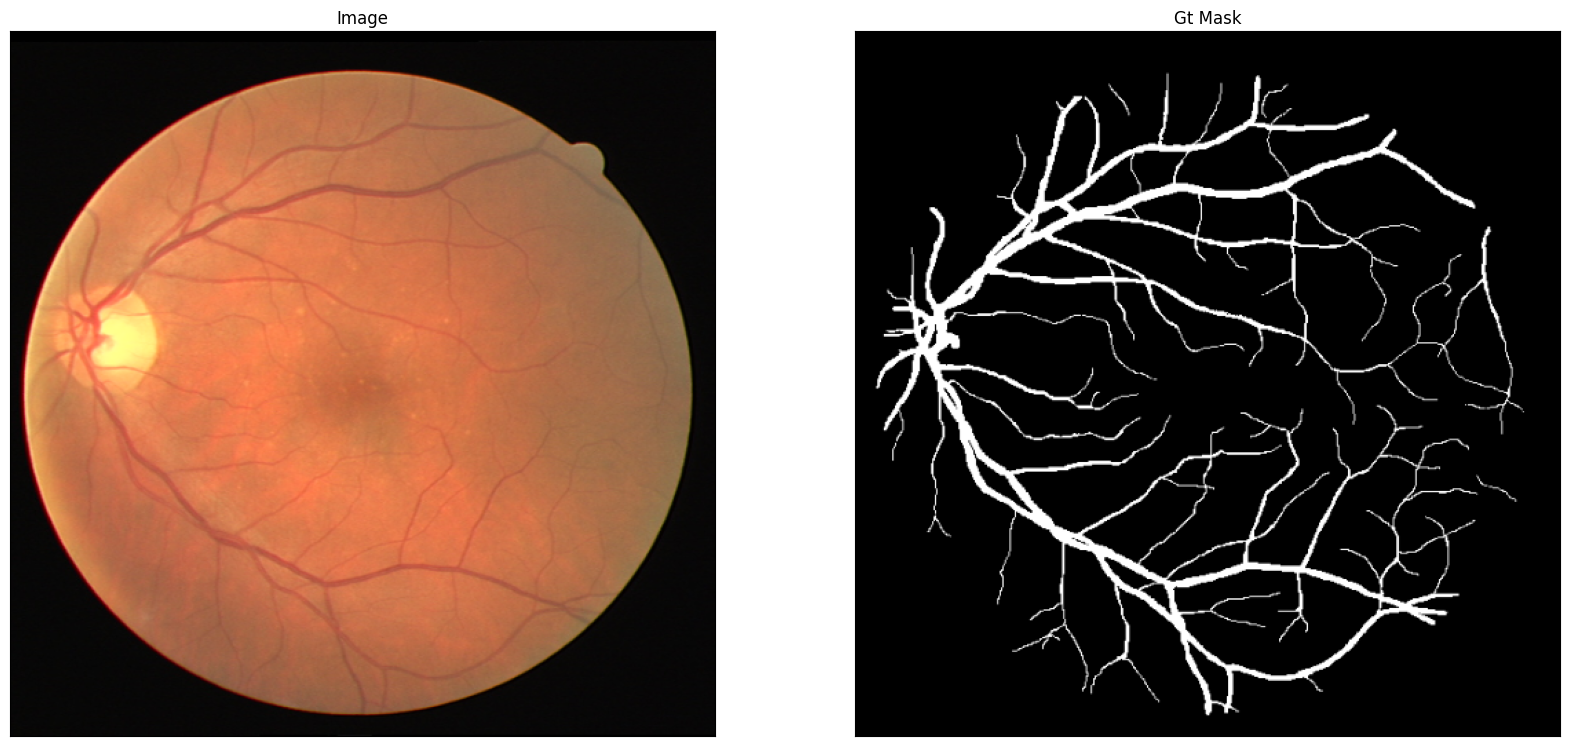

0.0 1.0
[0.0000000e+00 7.6293945e-06 2.2888184e-05 ... 9.9997711e-01 9.9999237e-01
 1.0000000e+00]


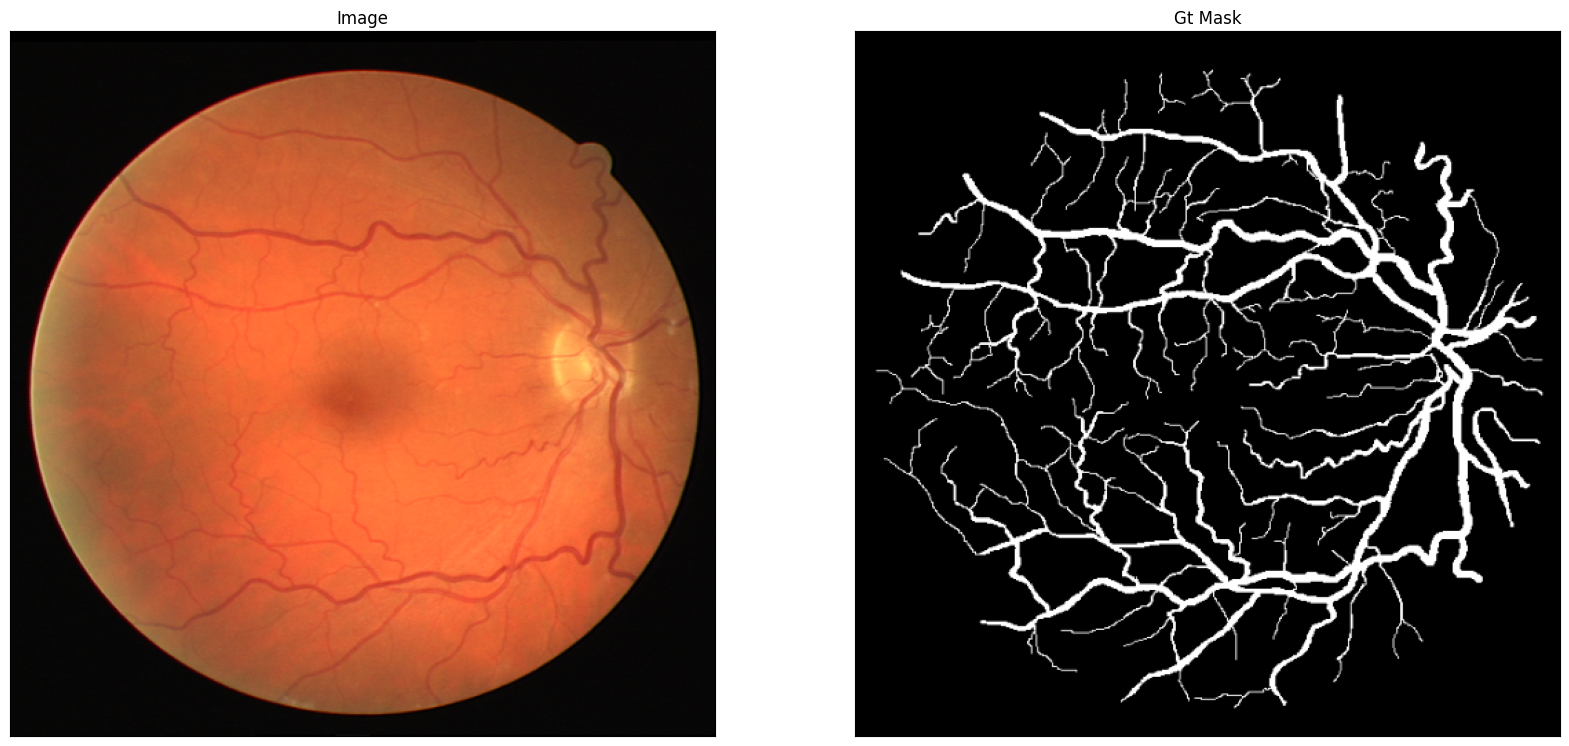

0.0 1.0
[0.0000000e+00 7.6293945e-06 2.2888184e-05 ... 9.9997711e-01 9.9999237e-01
 1.0000000e+00]


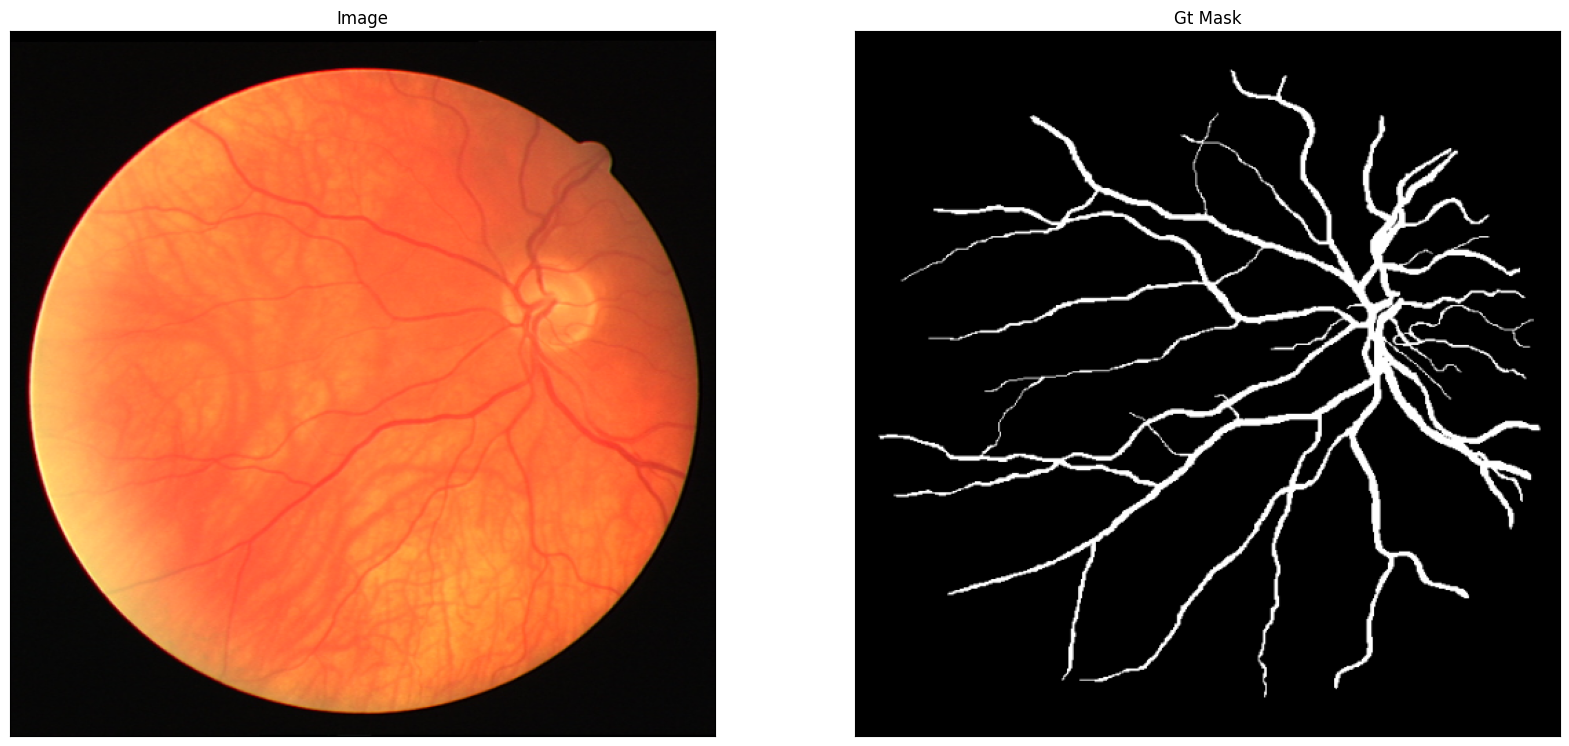

0.0 1.0
[0.0000000e+00 7.6293945e-06 2.2888184e-05 ... 9.9997711e-01 9.9999237e-01
 1.0000000e+00]


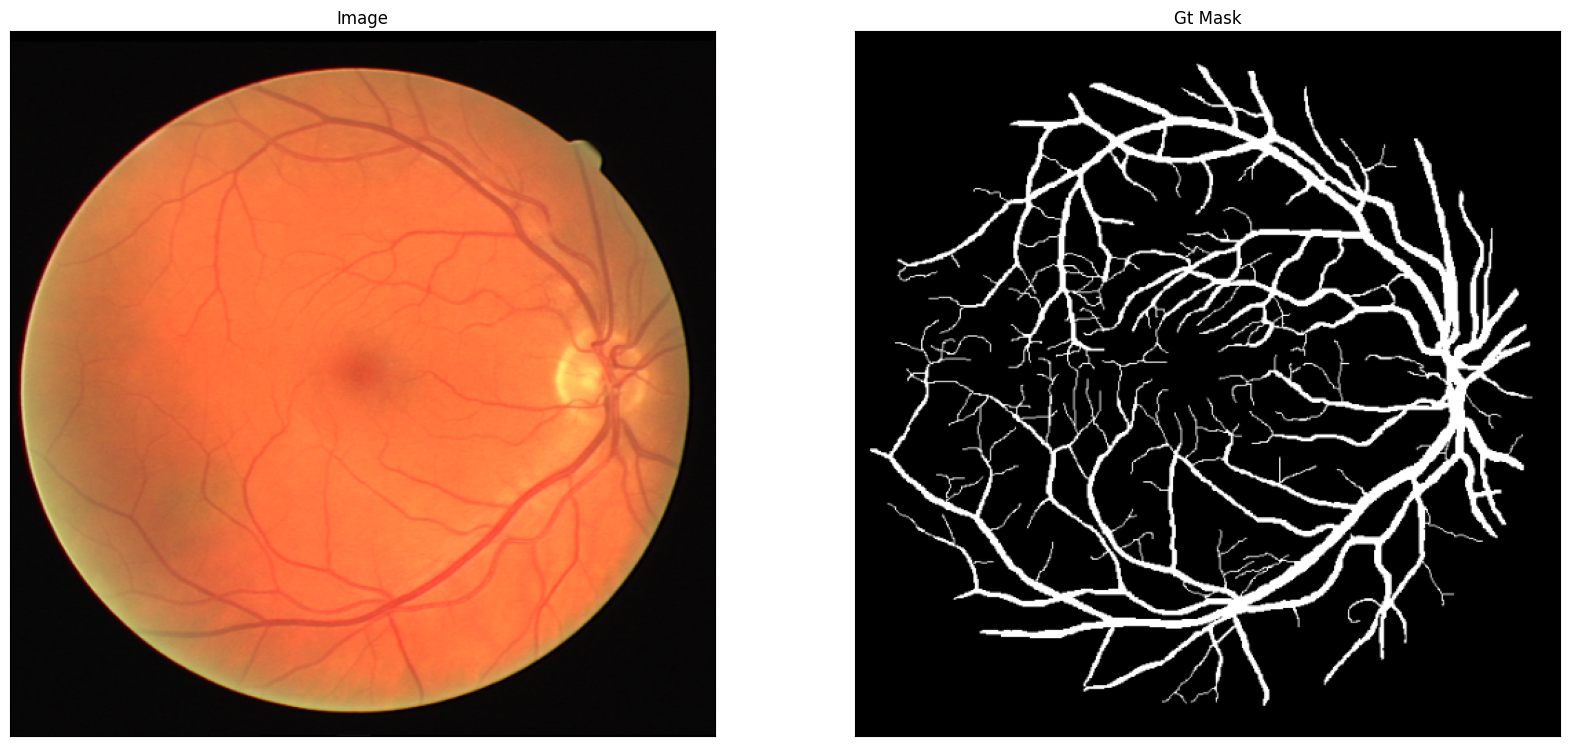

0.0 1.0
[0.0000000e+00 7.6293945e-06 2.2888184e-05 ... 9.9997711e-01 9.9999237e-01
 1.0000000e+00]


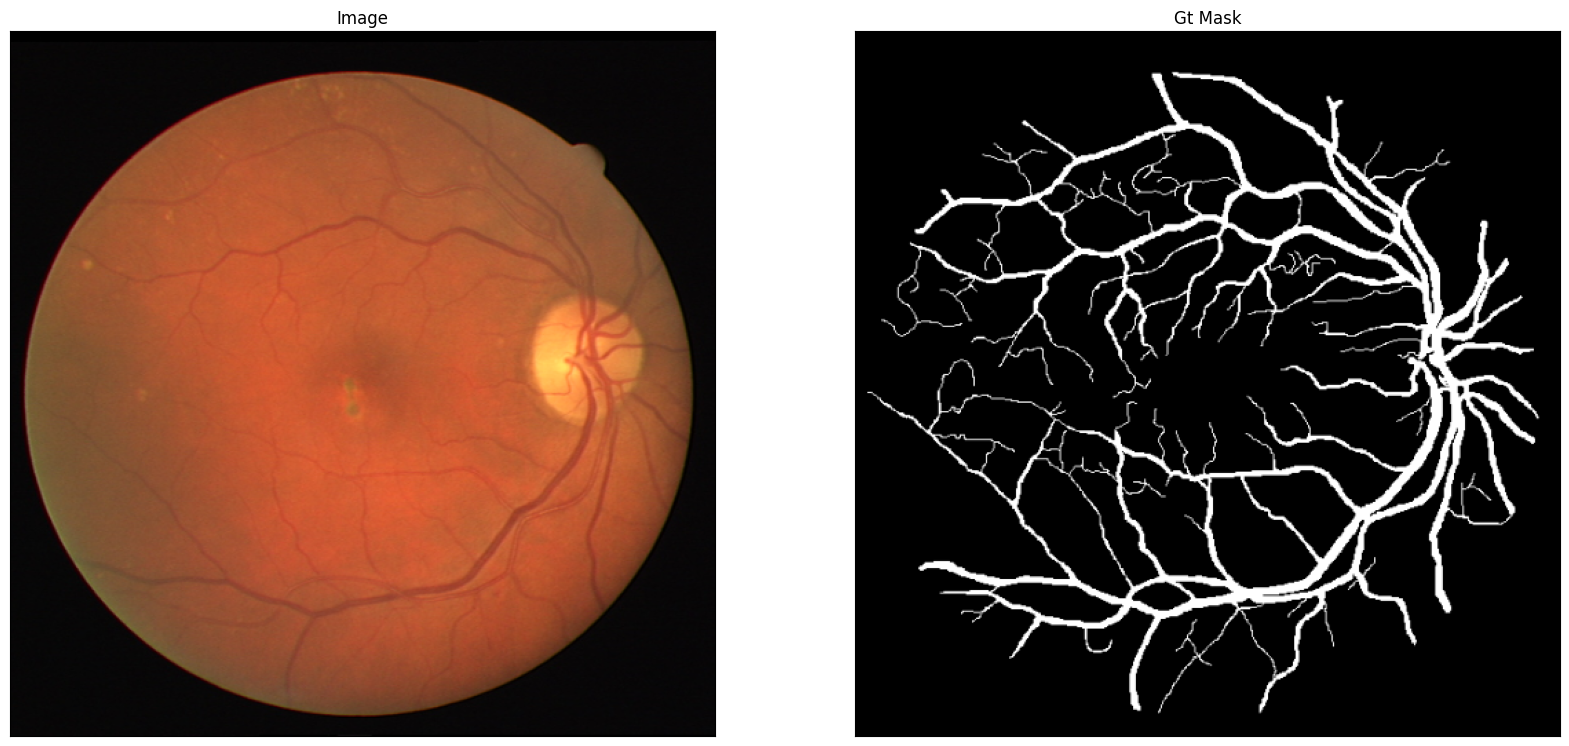

In [41]:
image, mask = next(iter(train_dataset.take(1)))
print(image.shape, mask.shape)

for (img, msk) in zip(image[:5], mask[:5]):
    print(mask.numpy().min(), mask.numpy().max())
    print(np.unique(mask.numpy()))
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(),
    )

# Build and train our neural network


![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
s = inputs
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

In [42]:
from tensorflow import keras

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
BACKBONE   = 'efficientnetb0'
n_classes  = 1
activation = 'sigmoid'
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None)
# model.summary(line_length=110)

# Callback : Monitoring Training Progress

In [46]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=50):
        self.dataset = dataset
        self.epoch_interval = epoch_interval

    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()

    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]

    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])

    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Compile and Fit

In [47]:
# define optomizer
optim = keras.optimizers.Adam(0.0001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

model.fit(
    train_dataset,
    callbacks=[DisplayCallback(train_dataset)],
    epochs=400
)

Epoch 1/400


ValueError: dtype='string' is not a valid dtype for Keras type promotion.

In [ ]:
model.save('seg.h5')
# model.save_weights('./seg.h5')